In [6]:
from scipy import io
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [8]:
# Loading the .mat files
mfcc = io.loadmat("mfcc.mat")
musigma = io.loadmat("MuSigma.mat")

In [9]:
# Subsetting mfcc vectors
mfccx = mfcc["X"]
# Subsetting mean from MuSigma
mean = musigma["mX"]
# Subsetting sigma from MuSigma
sigma = musigma["Sigma"]

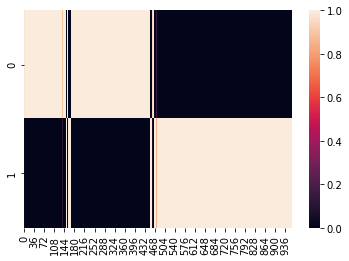

In [10]:
# Calculating p.d.f of mfcc vectors for piano music
P1 = stats.multivariate_normal.pdf(mfccx.T, mean[:,0], sigma[:,:,0]).reshape(1,962)
# Calculating p.d.f of mfcc vectors for clap sound
P2 = stats.multivariate_normal.pdf(mfccx.T, mean[:,1], sigma[:,:,1]).reshape(1,962)
# Conatenating two 1x962 matrices row-wise to get P which is a 2x962 matrix
P = np.concatenate((P1, P2), axis = 0)

# Normalizing P matrix to get posterior probabilities
Pnorm = P/P.sum(axis = 0)

# Plotting the posterior probabilities
ax = sns.heatmap(Pnorm)

In [ ]:
Pnorm

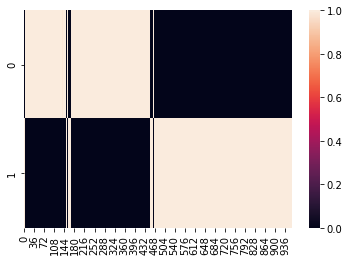

In [142]:
### Using transition matrix to compute posterior probability

# Defining transition matrix T
T = np.array([[0.9, 0.1], [0, 1]])

# Taking the first column from Pnorm matrix to the new matrix, as no prior state is available for first column
tranP = Pnorm[:,0].reshape(2,1)

for i in range(1,Pnorm.shape[1]):
    # Getting b, the index of the maximum of the two rows in each column in Pnorm
    b = Pnorm[:,i-1].argmax(axis = 0)
    # Subsetting bth row from transition matrix T
    selT = T[b, :]
    # Multiplying subsetted row selT with the column in Pnorm
    newP = (selT.T * Pnorm[:,i]).reshape(2,1)
    # Appending the vector computed in previous step to the new 
    tranP = np.concatenate((tranP, newP), axis = 1)
# Normalizing new matrix to compute posterior probability
tranPnorm = tranP/tranP.sum(axis = 0)
# Plotting the results
ax = sns.heatmap(tranPnorm)

In [143]:
### Implementing Viterbi ALgorithm

# Viterbi algorithm results will be stored in vitP0 for piano music
vitP0 = [Pnorm[0,0]]
# Viterbi algorithm results will be stored in vitP1 for clap sound
vitP1 = [Pnorm[1,0]]
# Initializing B0, as mentioned in equation 11 of assignment
B0 = [(T[:,0] * Pnorm[:,0]).argmax(axis = 0)]
# Initializing B1, just like B0, but for the clap sound
B1 = [(T[:,1] * Pnorm[:,0]).argmax(axis = 0)]

for i in range(1,Pnorm.shape[1]):
    
    # Calculating B0, as mentioned in equation 11 of assignment
    b0 = (T[:,0] * Pnorm[:,i-1]).argmax(axis = 0)
    B0.append(b0)
    # Calculating vitP0, as in equation 12 of assignment
    vitP0.append(T[b0,0] * Pnorm[0,i-1] * Pnorm[0,i])
    
    # Steps similar as above, but for clap sound
    b1 = (T[:,1] * Pnorm[:,i-1]).argmax(axis = 0)
    B1.append(b1)
    vitP1.append(T[b1,1] * Pnorm[1,i-1] * Pnorm[1,i])


In [144]:
### Backtracking results from Viterbi Algorithm

# Concatenating results vitP0 and vitP1 to form posterior probability matrix
vitP = np.vstack([vitP0, vitP1])
# Normalizing as mentioned in step 9 of assignment
vitPnorm = vitP/vitP.sum(axis = 0)
# Appending B0 and B1 to get B
B = np.vstack([B0, B1])

# Bactracking results are stored in res
res = [None]*(vitPnorm.shape[1])
res[961] = 1

for i in range(vitPnorm.shape[1]-1,0,-1):
    # Backtracking as mentioned in step 10 of assignment
    b = vitPnorm[:,i].argmax(axis = 0)
    res[i-1] = B[b, i-1]

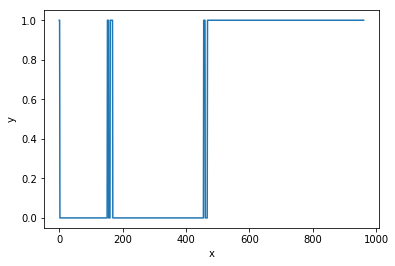

In [140]:
### Plotting backtracked results

df = pd.DataFrame({"x": list(range(962)),"y": res})
ax = sns.lineplot(x = "x", y = "y", data = df)